In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.precision', 2)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e6/sample_submission.csv
/kaggle/input/playground-series-s4e6/train.csv
/kaggle/input/playground-series-s4e6/test.csv


In [2]:
!pip install --no-deps scikeras

### Load Python Packages

In [3]:
#basics
import numpy as np
import pandas as pd 
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.base import clone
from sklearn import set_config
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

#preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer, quantile_transform

#statistics
from scipy.stats import randint, mode, pearsonr, norm, skew, kurtosis 
from scipy.optimize import minimize

#transformers and pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

#feature engineering
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
min_features_to_select = 1

#algorithms
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingRegressor, VotingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

#model evaluation
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, log_loss, auc, accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_squared_error, make_scorer, RocCurveDisplay, confusion_matrix
from sklearn.metrics import roc_curve, matthews_corrcoef, cohen_kappa_score

#Optuna and visualization tools
import optuna
USE_OPTUNA = False
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv1D
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
import tensorflow.keras.backend as K

random_state = 42

tf.keras.utils.set_random_seed(random_state)
tf.config.experimental.enable_op_determinism()

from scikeras.wrappers import KerasClassifier
from matplotlib.colors import LinearSegmentedColormap

SEED = 42
n_splits = 5

### First Look into Data

#### Check for missing values

In [4]:
# Read the data
train_df = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv', index_col=[0])
test_df = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv', index_col=[0])
#original_df = pd.read_csv('/kaggle/input/predict-students-dropout-and-academic-success/data.csv')
#original_df.index.names = ['id']

# reserve a clean copy for modelling
pipe_data = train_df.copy()
pipe_test = test_df.copy()
#pipe_original = original_df.copy()

train_df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.43,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.00,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.00,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.82,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.93,0,7.6,2.6,0.32,Graduate


In [5]:
train_df.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

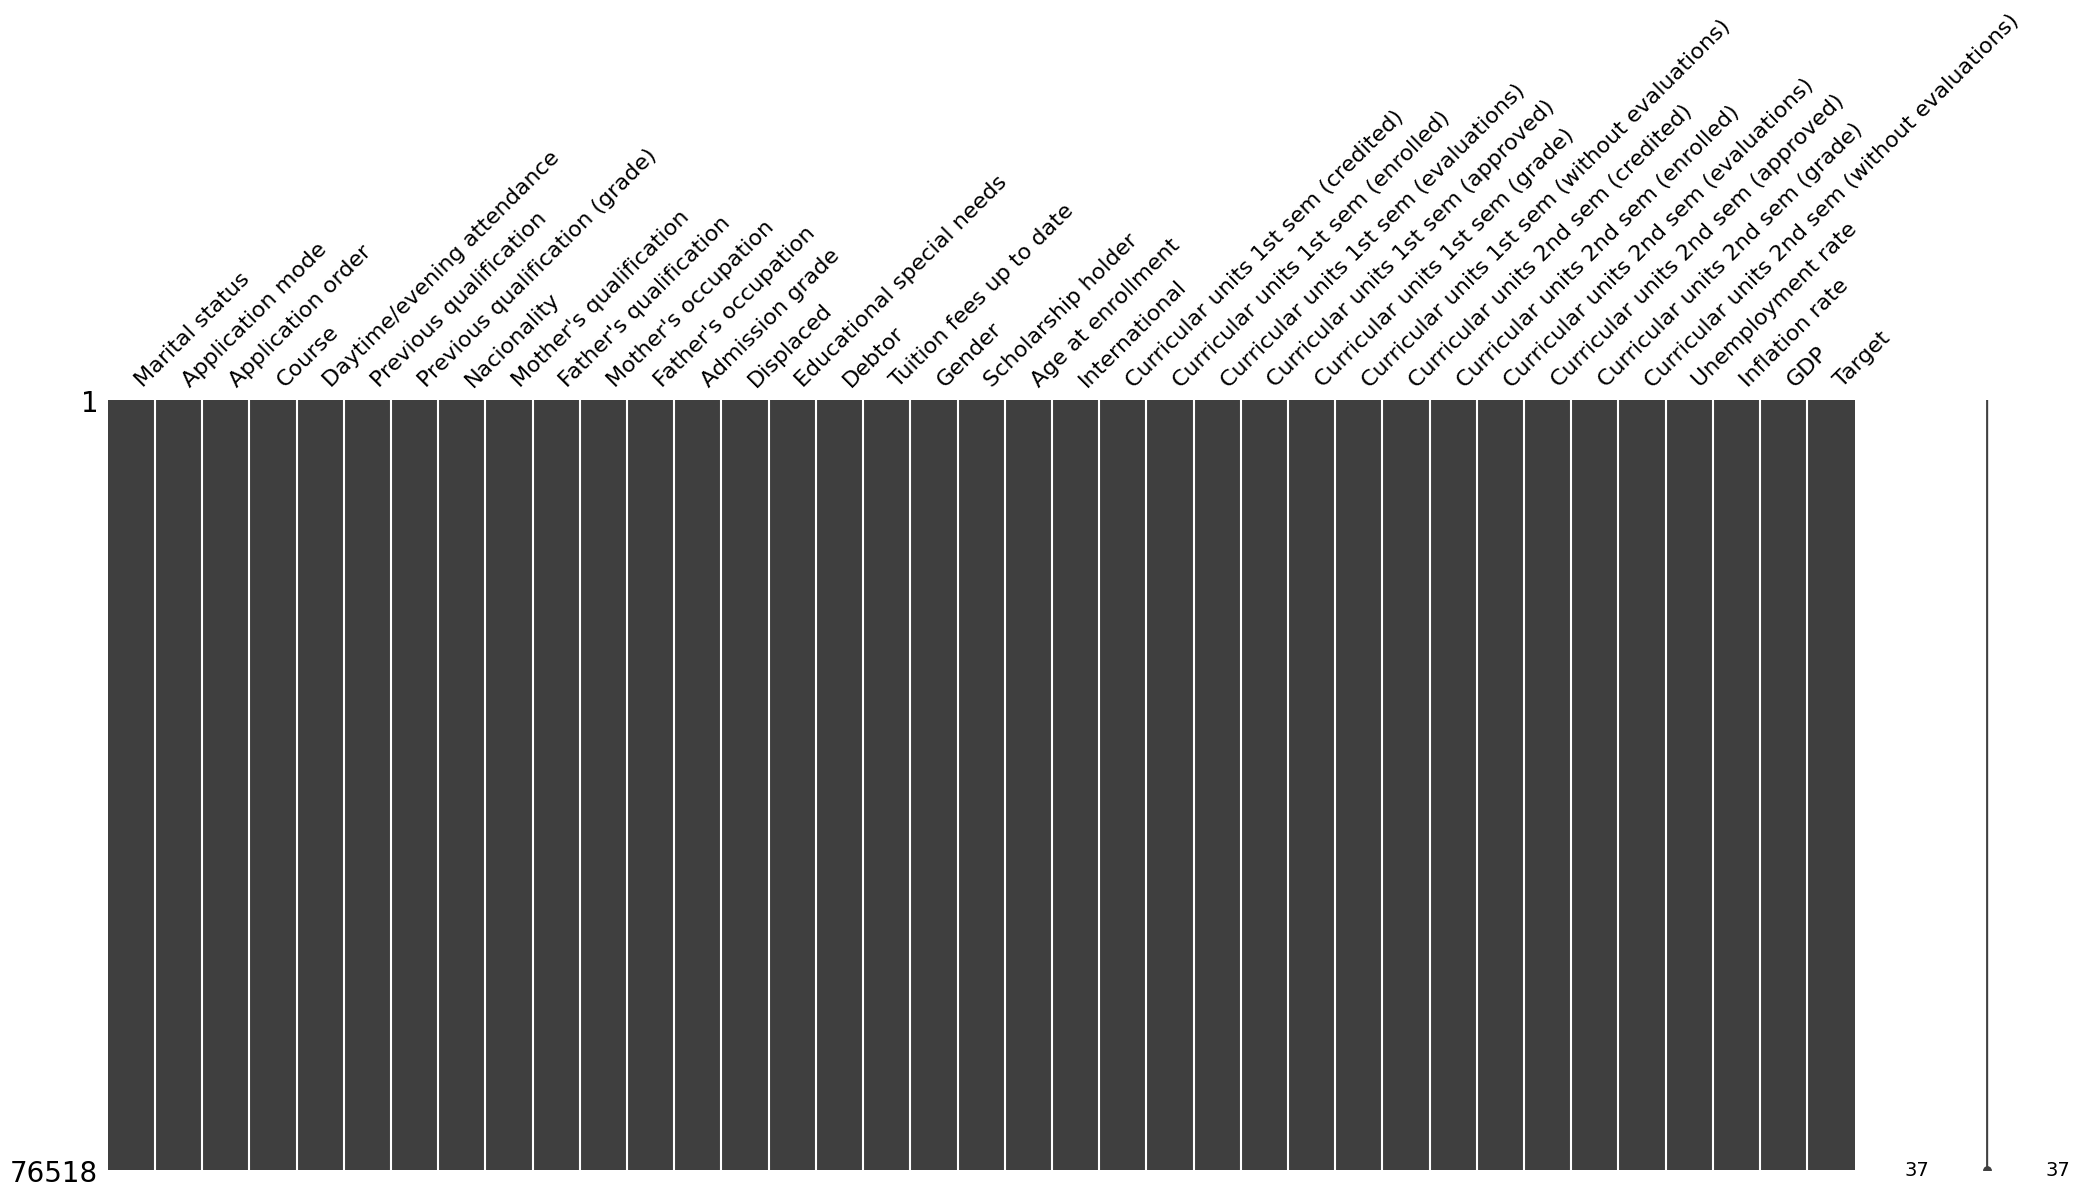

In [6]:
%matplotlib inline
msno.matrix(train_df)
plt.show()

In [7]:
missing = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False))
missing.columns = ["missing_count"]
missing = missing.loc[(missing != 0).any(axis = 1)]
missing["missing_percent"] = missing[0:] / len(train_df)*100
missing.style.background_gradient('viridis')

,missing_count,missing_percent


### Descriptive statistics

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital status,76518.0,1.11e+00,0.44,1.00,1.00,1.00,1.00,6.00
Application mode,76518.0,1.61e+01,16.68,1.00,1.00,17.00,39.00,53.00
Application order,76518.0,1.64e+00,1.23,0.00,1.00,1.00,2.00,9.00
Course,76518.0,9.00e+03,1803.44,33.00,9119.00,9254.00,9670.00,9991.00
Daytime/evening attendance,76518.0,9.15e-01,0.28,0.00,1.00,1.00,1.00,1.00
Previous qualification,76518.0,3.66e+00,8.62,1.00,1.00,1.00,1.00,43.00
Previous qualification (grade),76518.0,1.32e+02,11.00,95.00,125.00,133.10,140.00,190.00
Nacionality,76518.0,1.23e+00,3.39,1.00,1.00,1.00,1.00,109.00
Mother's qualification,76518.0,1.98e+01,15.40,1.00,1.00,19.00,37.00,44.00
Father's qualification,76518.0,2.34e+01,14.92,1.00,4.00,19.00,37.00,44.00


### Grouping features for preprocessing purposes

In [9]:
train_df.nunique().sort_values()

Scholarship holder                                   2
International                                        2
Gender                                               2
Tuition fees up to date                              2
Daytime/evening attendance                           2
Debtor                                               2
Educational special needs                            2
Displaced                                            2
Target                                               3
Marital status                                       6
Application order                                    8
Unemployment rate                                   11
Curricular units 2nd sem (without evaluations)      11
GDP                                                 11
Curricular units 1st sem (without evaluations)      12
Inflation rate                                      13
Nacionality                                         18
Course                                              19
Curricular

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

In [11]:
# Store numerical and categorical features to different lists for visualization purposes
feature_list = [feature for feature in train_df.columns if not feature  == "Target"]

binary_features = ['Scholarship holder','International','Gender','Tuition fees up to date',
                   'Daytime/evening attendance','Debtor','Educational special needs','Displaced']

target = "Target"

#categorical_features = []

continuous_features = list(set(feature_list) - set(binary_features))

assert feature_list.sort() == (continuous_features + binary_features).sort()

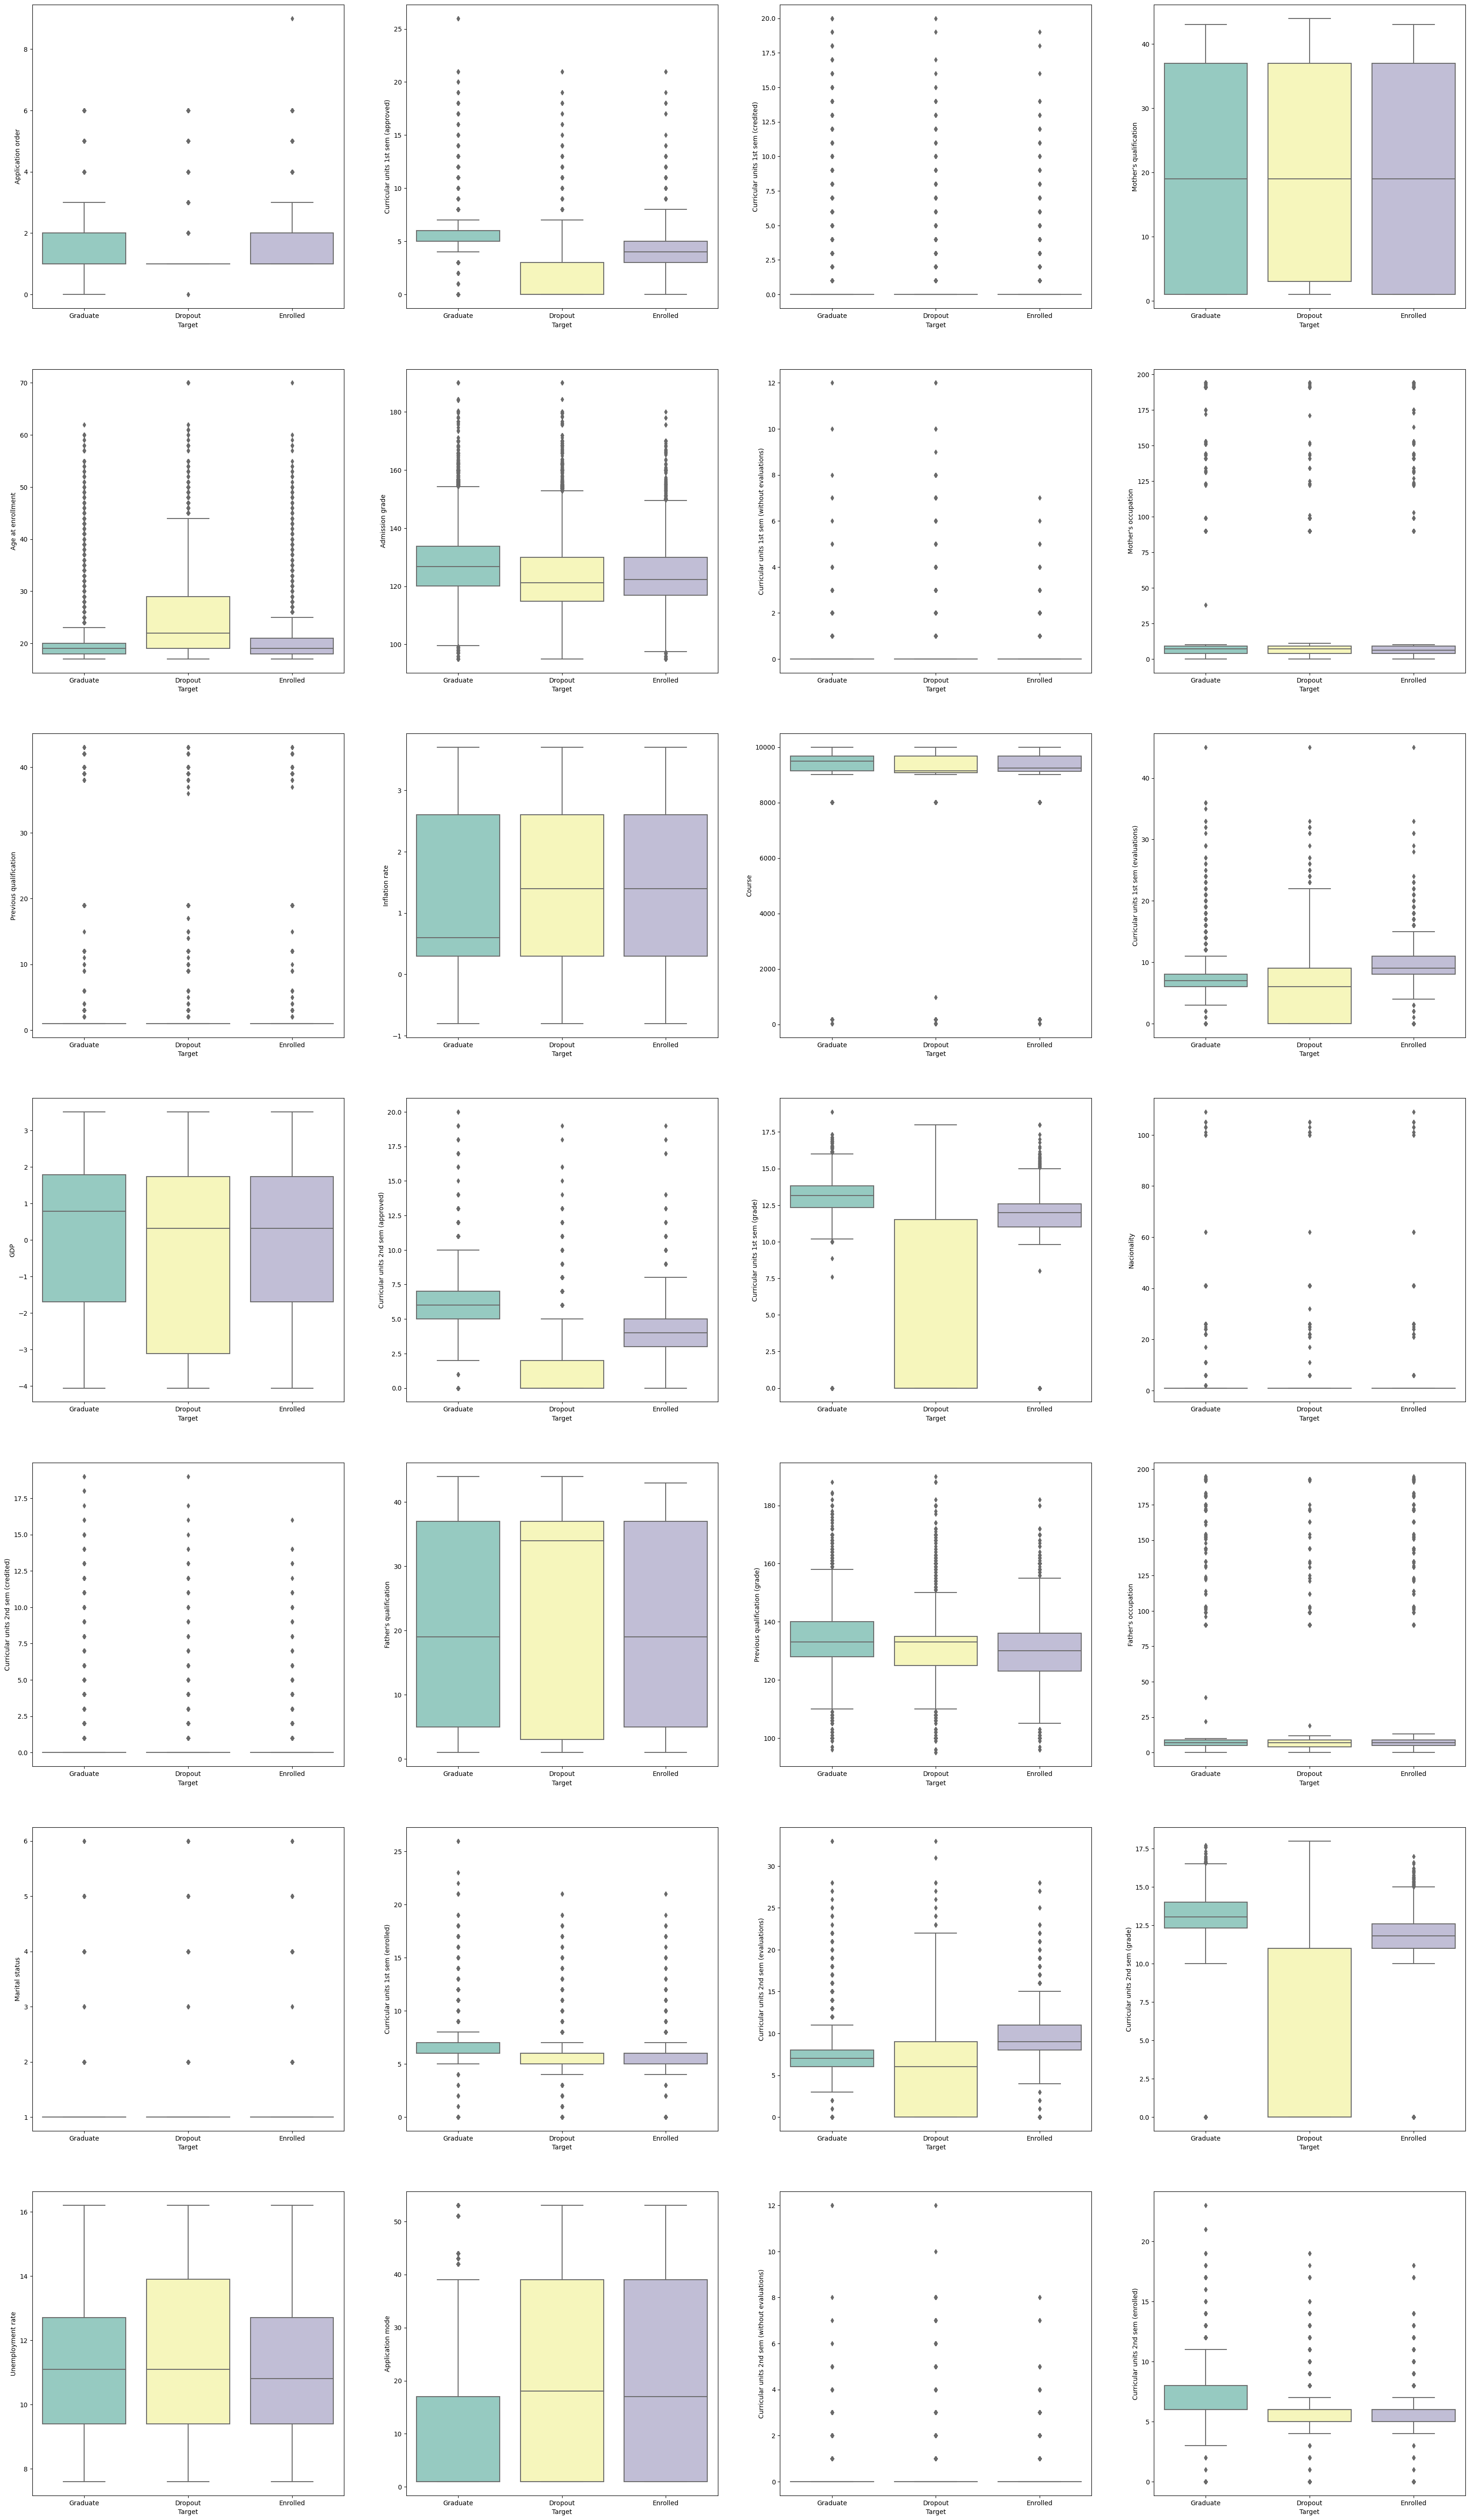

In [12]:
fig, ax = plt.subplots(7, 4, figsize=(40, 70))
for var, subplot in zip(continuous_features, ax.flatten()):
    sns.boxplot(x='Target', y=var, data=train_df, ax=subplot, palette='Set3')

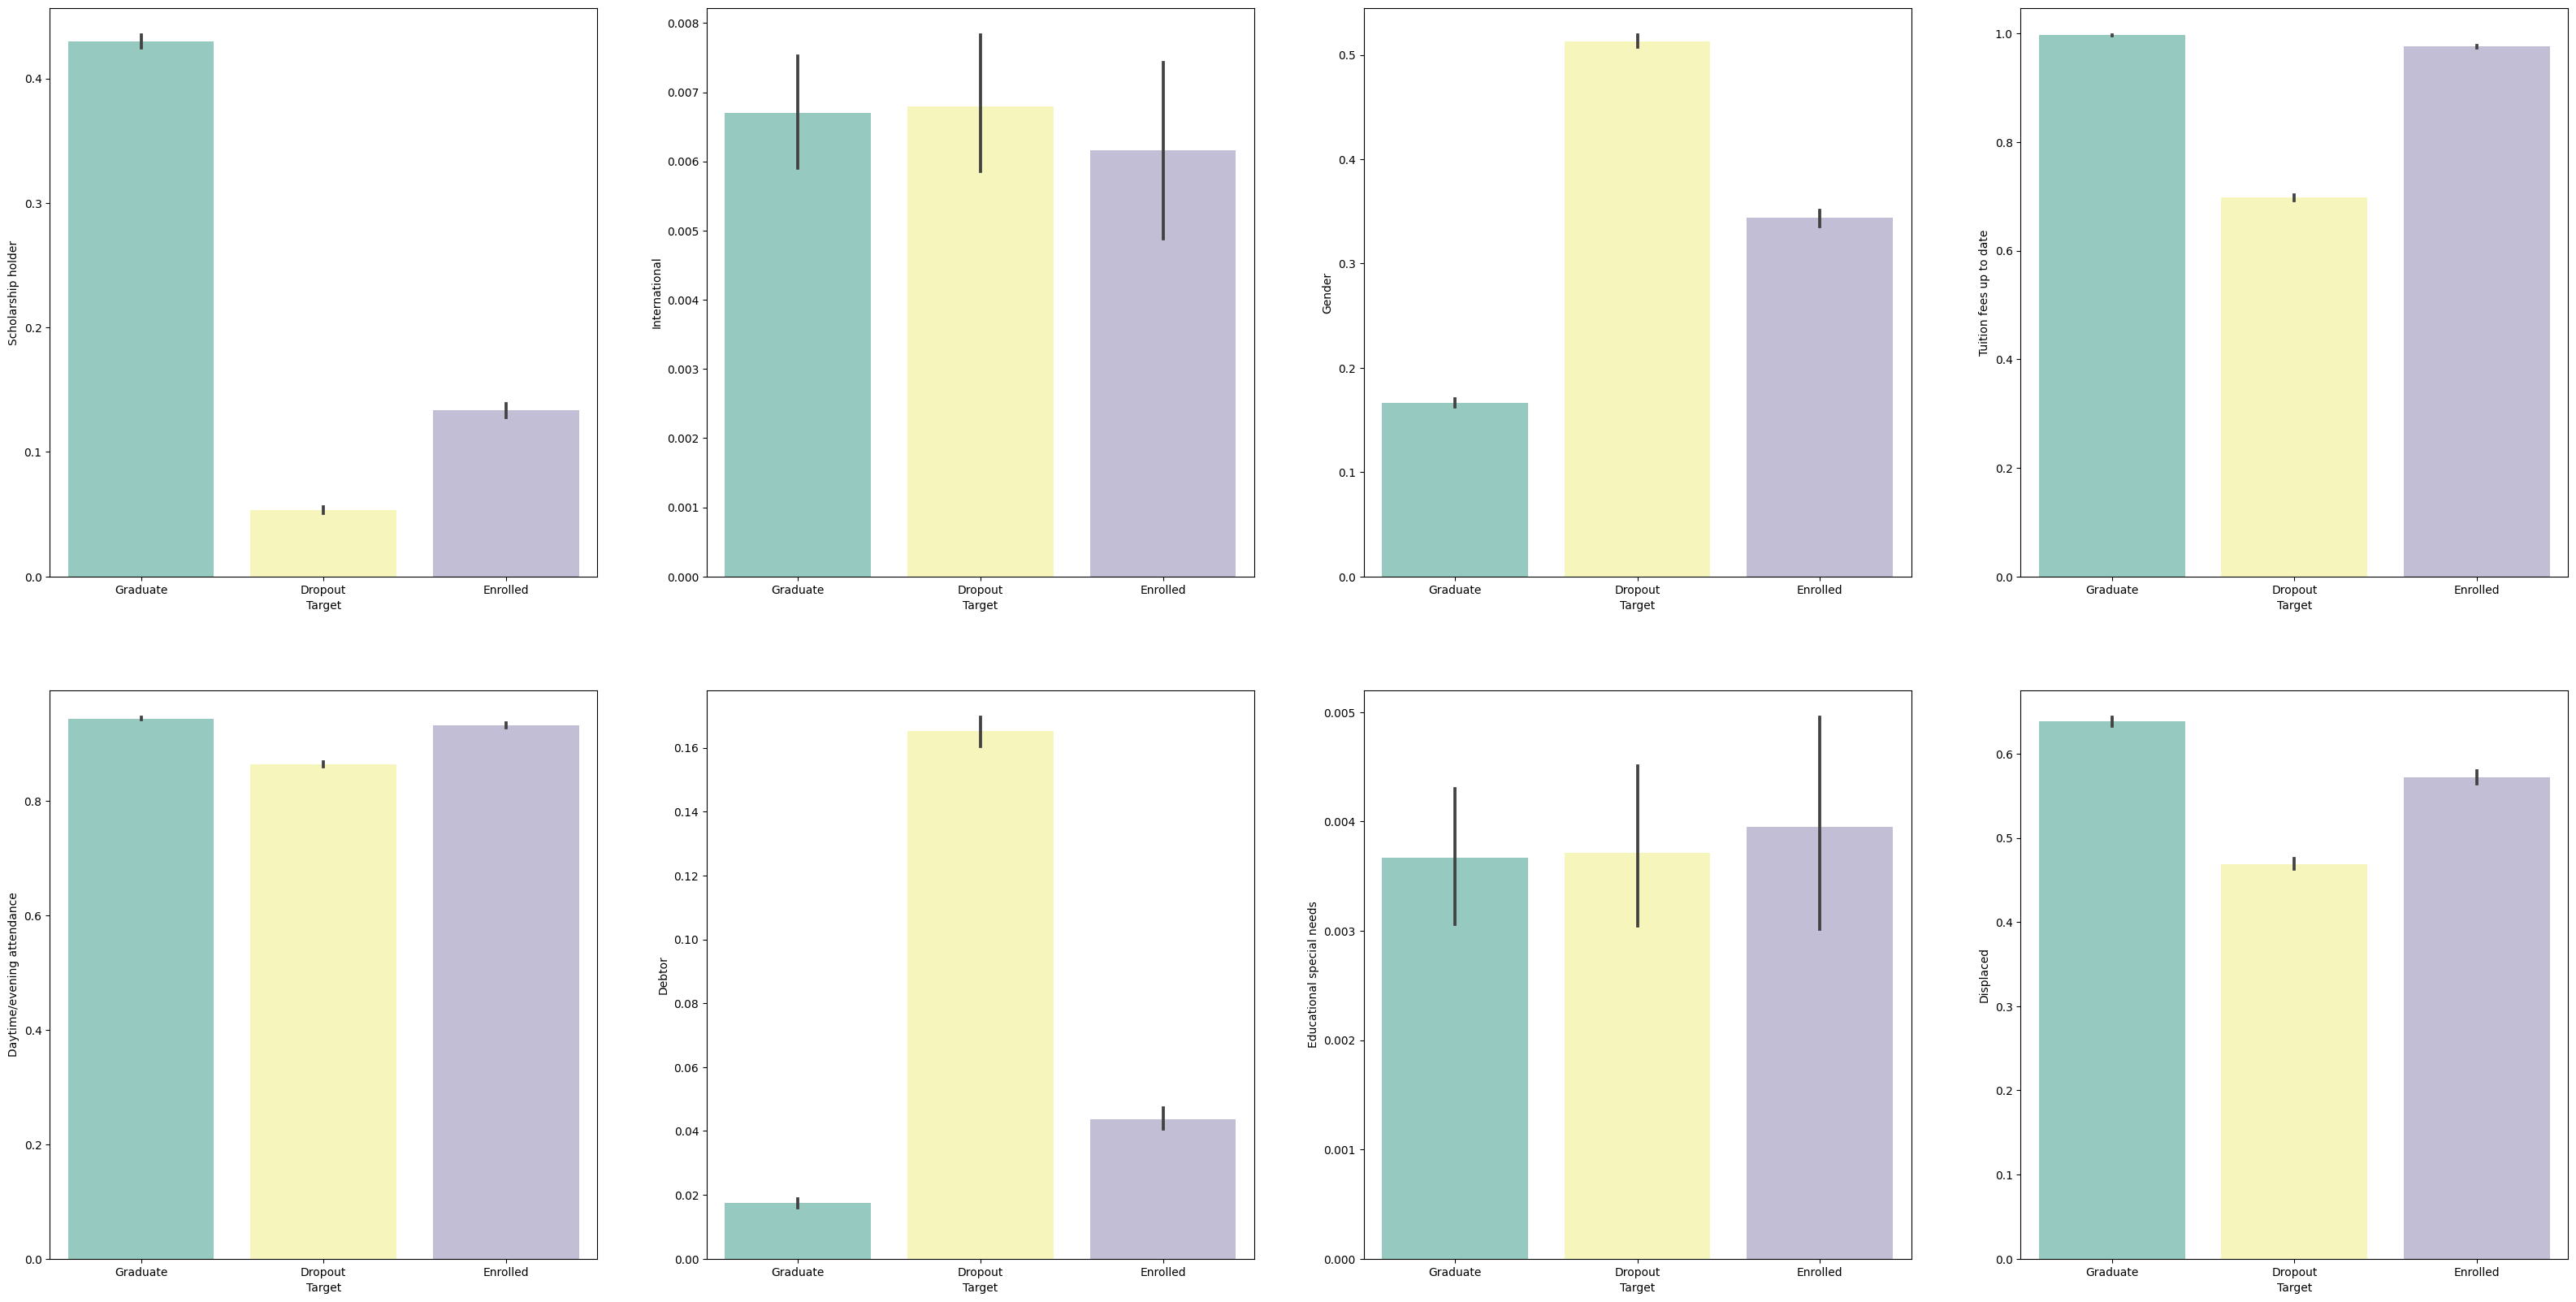

In [13]:
fig, ax = plt.subplots(2, 4, figsize=(40, 20))
for var, subplot in zip(binary_features, ax.flatten()):
    sns.barplot(x='Target', y= var, data=train_df, ax=subplot, palette='Set3')

### Target Distribution

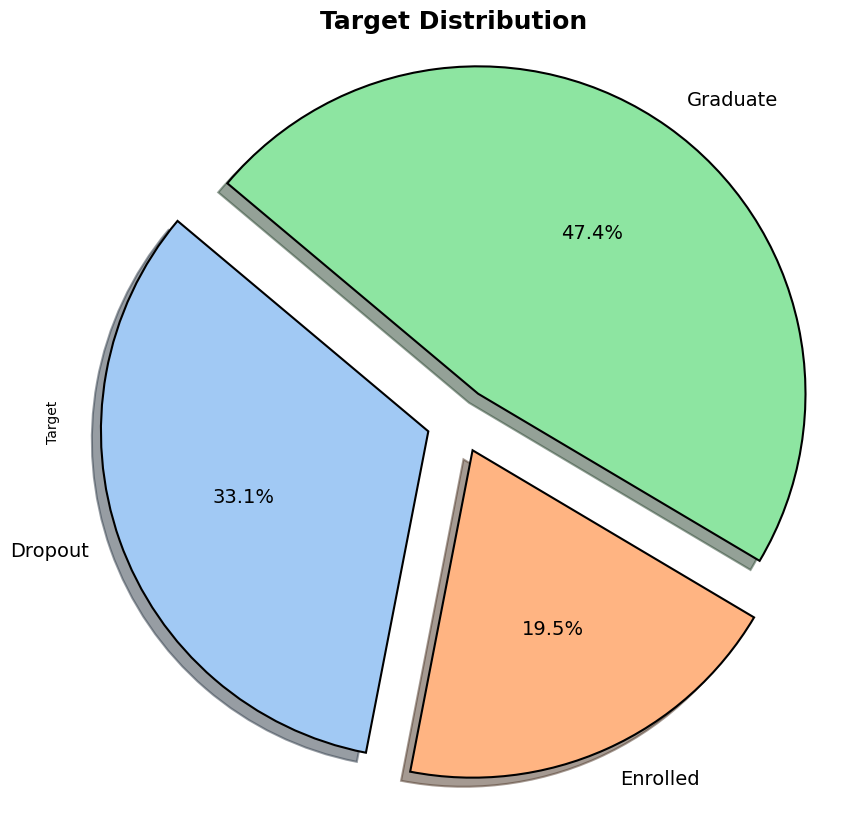

In [14]:
plt.figure(figsize=(10, 10))
palette_color = sns.color_palette('pastel')
explode = [0.1 for _ in range(train_df['Target'].nunique())]

# Plotting
train_df.groupby('Target')['Target'].count().plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,  # Adding shadow for better visibility
    startangle=140,  # Start angle for better alignment
    textprops={'fontsize': 14},  # Adjust text size
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}  # Adding edge color and width
)

# Adding a title
plt.title('Target Distribution', fontsize=18, weight='bold')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Displaying the plot
plt.show()

### Feature Engineering

In [15]:
# Mutual Information score
y_sampled = train_df.Target
mutual_df = train_df[feature_list ]

mutual_info = mutual_info_classif(mutual_df, y_sampled, random_state=random_state)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
Curricular units 2nd sem (approved),0.480612
Curricular units 2nd sem (grade),0.415702
Curricular units 1st sem (approved),0.406072
Curricular units 1st sem (grade),0.365919
Curricular units 2nd sem (evaluations),0.198004
Curricular units 1st sem (evaluations),0.190375
Course,0.118762
Tuition fees up to date,0.108057
Admission grade,0.107321
Age at enrollment,0.095786


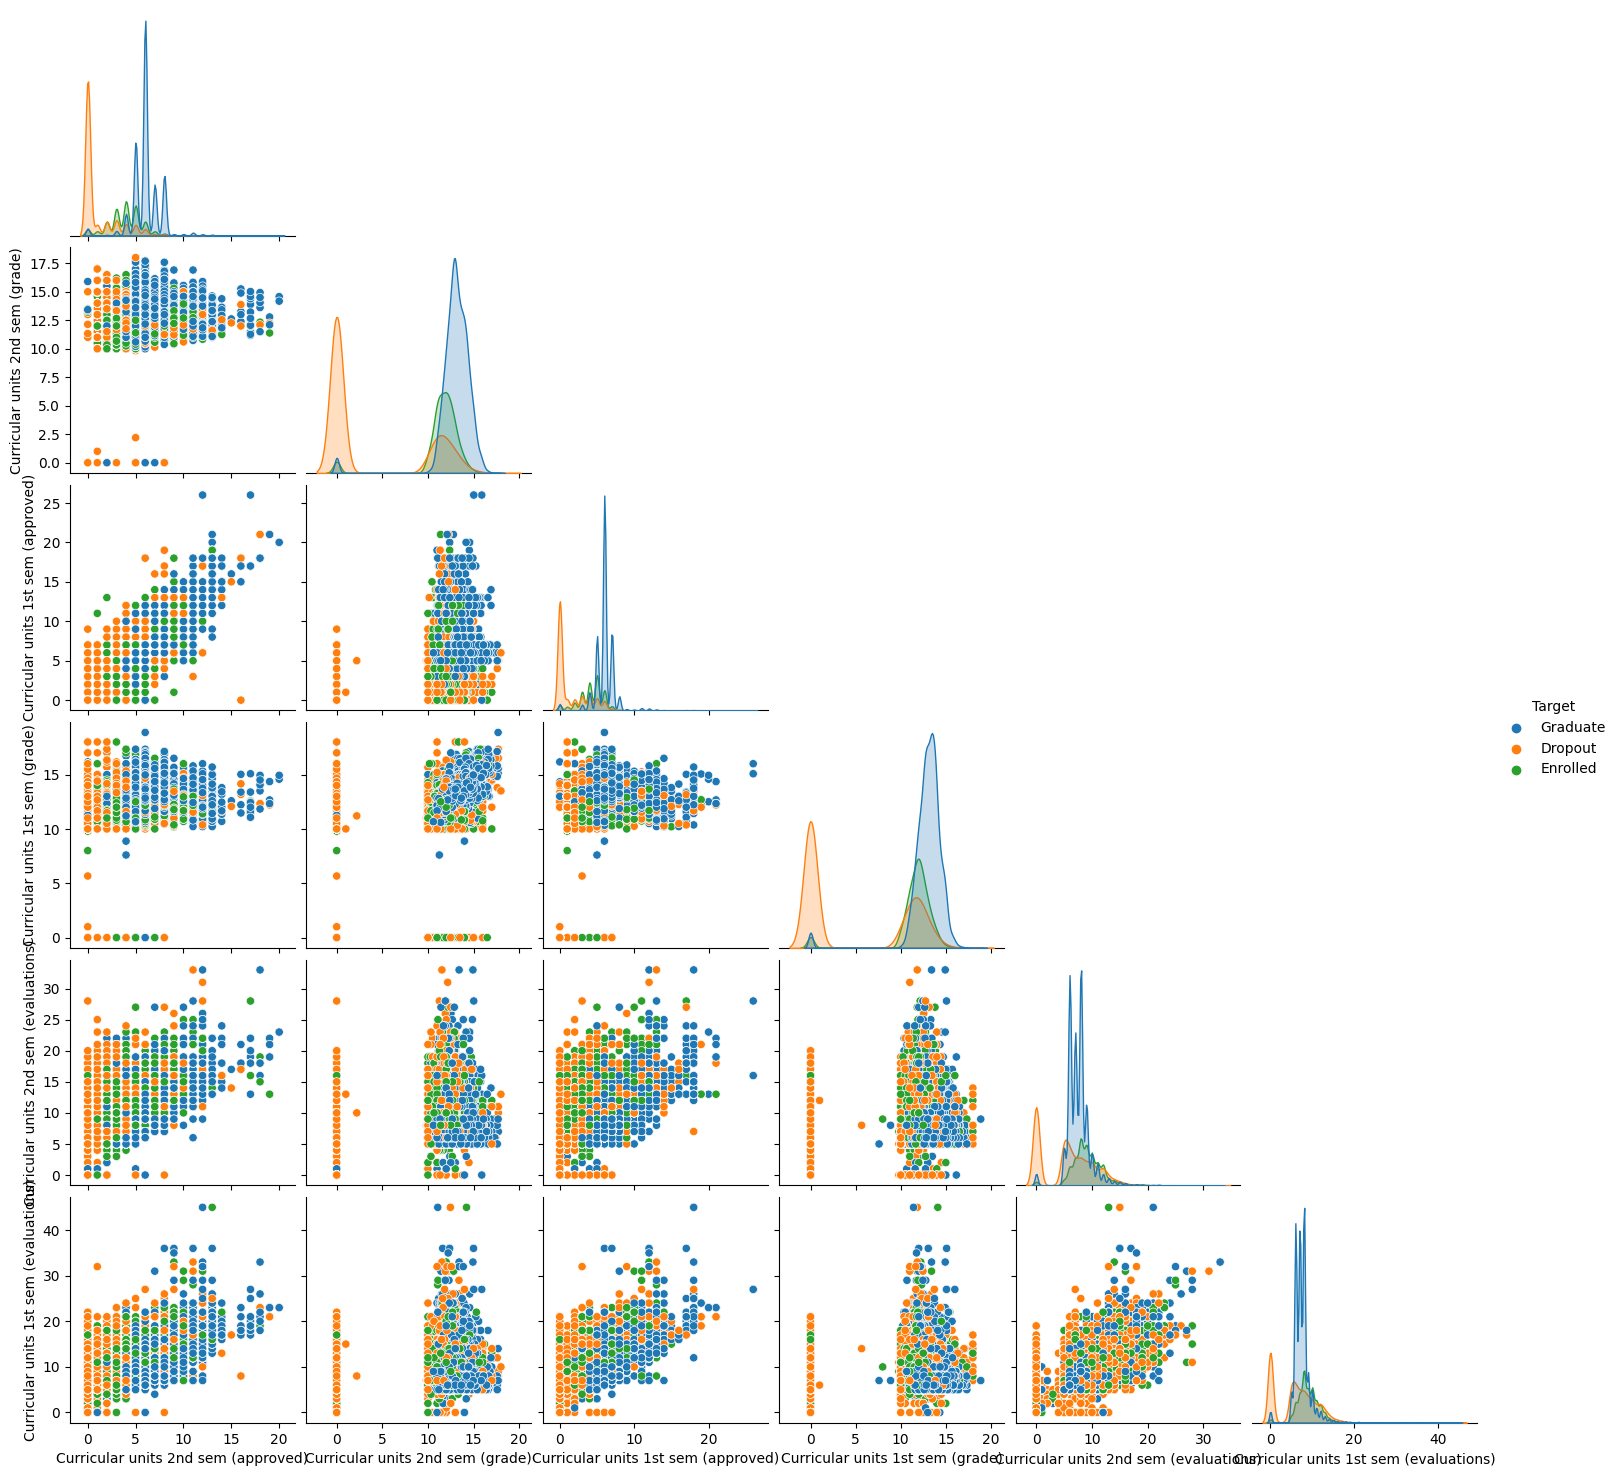

In [16]:
#Pair-plot for most important features
most_important_features = mutual_info[mutual_info['Numerical_Feature_MI'] > 0.15].index.tolist()
sns.pairplot(train_df[most_important_features + ["Target"]], hue="Target",  corner=True)

### Pre-processing

In [17]:
# Preprocessing object for neural net
nn_preprocessor = MinMaxScaler()

In [18]:
#Just simple target encoding
label_encoder = LabelEncoder()
pipe_data['Target'] = label_encoder.fit_transform(pipe_data['Target'])
#pipe_original['Target'] = label_encoder.transform(pipe_original['Target'])

### Modeling

In [19]:
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=random_state) 

In [20]:
def cross_validate_score(model, data, cv=cv, test_data=pipe_test, label='Target', include_original=False):
    X = data.copy()
    y = X.pop(label)
    
    # Initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X), 3))  # Adjust for class probabilities
    train_scores, val_scores = [], []
    
    # Training model and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Define train set
        X_train = X.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        
        # Define validation set
        X_val = X.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        
        if include_original:
            X_train = pd.concat([pipe_original.drop(label, axis=1), X_train]).reset_index(drop=True)
            y_train = pd.concat([pipe_original[label], y_train]).reset_index(drop=True)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        train_preds = model.predict(X_train)
        val_preds_proba = model.predict_proba(X_val)  # Get class probabilities
        
        # Store validation predictions
        val_predictions[val_idx] = val_preds_proba
        
        # Evaluate model for a fold
        val_preds = np.argmax(val_preds_proba, axis=1)  # Get predicted classes for accuracy score
        train_score = accuracy_score(y_train, train_preds)
        val_score = accuracy_score(y_val, val_preds)
        
        print(f'Fold {fold}: {val_score:.5f}')
        
        # Append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    # Refit the model on the entire dataset, including the original data
    if include_original:
        X_full = pd.concat([pipe_original.drop(label, axis=1), X]).reset_index(drop=True)
        y_full = pd.concat([pipe_original[label], y]).reset_index(drop=True)
    else:
        X_full = X
        y_full = y
    
    model.fit(X_full, y_full)
    
    # Make final predictions on the test set
    test_predictions_proba = model.predict_proba(test_data)  # Get class probabilities
    
    print(f'Val Score: {np.mean(val_scores):.7f} ± {np.std(val_scores):.7f} | Train Score: {np.mean(train_scores):.7f} ± {np.std(train_scores):.7f} | {label}')
    
    return val_scores, val_predictions, test_predictions_proba

In [21]:
cv_summary, oof_predictions_df, submission_predictions_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

### XGBoost

In [22]:
xgb_optuna_params = {
    'n_estimators': 929,
    'alpha': 2.287466581490129e-05,
    'subsample': 0.8766675651018592,
    'colsample_bytree': 0.288332829334817,
    'max_depth': 8,
    'min_child_weight': 6,
    'learning_rate': 0.024083411832750343,
    'gamma': 0.001816649055813574
}

xgb_tuned = XGBClassifier(**xgb_optuna_params, random_state=random_state)

In [23]:
%%time
cv_summary['xgb'], oof_predictions_df[['xgb_0', 'xgb_1', 'xgb_2']], submission_predictions_df[['xgb_0', 'xgb_1', 'xgb_2']] = cross_validate_score(xgb_tuned, data=pipe_data, include_original=False)

Fold 0: 0.83664
Fold 1: 0.83370
Fold 2: 0.83220
Fold 3: 0.83206
Fold 4: 0.83389
Val Score: 0.8336992 ± 0.0016519 | Train Score: 0.8926723 ± 0.0003571 | Target
CPU times: user 14min 35s, sys: 3.66 s, total: 14min 38s
Wall time: 3min 46s


### Lightgbm

In [24]:
lgbm_optuna_params = {
    'n_estimators': 1894,
    'max_depth': 23,
    'learning_rate': 0.024309983270196903,
    'min_data_in_leaf': 27,
    'subsample': 0.40065361124232945,
    'max_bin': 267,
    'feature_fraction': 0.1326832138080814
}

lgbm_tuned = LGBMClassifier(**lgbm_optuna_params, random_state=random_state, verbose=-1)

In [25]:
%%time
cv_summary['lgbm'], oof_predictions_df[['lgbm_0', 'lgbm_1','lgbm_2']], submission_predictions_df[['lgbm_0', 'lgbm_1','lgbm_2']] = cross_validate_score(lgbm_tuned, data = pipe_data, include_original=False)

Fold 0: 0.83638
Fold 1: 0.83416
Fold 2: 0.83187
Fold 3: 0.83121
Fold 4: 0.83487
Val Score: 0.8336992 ± 0.0019137 | Train Score: 0.8756567 ± 0.0001790 | Target
CPU times: user 10min 20s, sys: 11.8 s, total: 10min 32s
Wall time: 10min 4s


In [26]:
lgbm4_params = {
    'objective': 'multiclassova',
    'n_estimators': 1116,
    'learning_rate': 0.010094507279170323,
    'num_leaves': 274,
    'max_depth': 15,
    'min_child_weight': 0.5585980477690918,
    'subsample': 0.39806510795226885,
    'colsample_bytree': 0.37301505469464413,
    'reg_alpha': 0.008860988903282671,
    'reg_lambda': 0.16942264264852677,
    'boosting_type': 'goss',
    'top_rate': 0.2196694108758759,
    'other_rate': 0.15278840726592346
}

lgbm_tuned4 = LGBMClassifier(**lgbm4_params, random_state=random_state, verbose=-1)

In [27]:
%%time
cv_summary['lgbm4'], oof_predictions_df[['lgbm4_0','lgbm4_1','lgbm4_2']], submission_predictions_df[['lgbm4_0', 'lgbm4_1','lgbm4_2']] = cross_validate_score(lgbm_tuned4, data = pipe_data, include_original=False)

Fold 0: 0.83468
Fold 1: 0.83240
Fold 2: 0.83246
Fold 3: 0.82840
Fold 4: 0.83219
Val Score: 0.8320264 ± 0.0020282 | Train Score: 0.9359040 ± 0.0006497 | Target
CPU times: user 22min 58s, sys: 4.06 s, total: 23min 2s
Wall time: 23min 3s


In [28]:
lgbm8_params = {
    'n_estimators':500,
    'learning_rate': 0.02564559283662533,
    'num_leaves': 189,
    'max_depth': 10,
    'min_child_weight': 0.005741867838447388,
    'subsample': 0.49251010717189025,
    'colsample_bytree': 0.3455645217452976,
    'reg_alpha': 0.7006509393112378,
    'reg_lambda': 0.005109461190524077,
    'boosting_type': 'goss',
    'top_rate': 0.42390823458789206,
    'other_rate': 0.203380469247538
}

lgbm_tuned8 = LGBMClassifier(**lgbm8_params, random_state=random_state, verbose=-1)

In [29]:
%%time
cv_summary['lgbm8'], oof_predictions_df[['lgbm8_0', 'lgbm8_1','lgbm8_2']], submission_predictions_df[['lgbm8_0', 'lgbm8_1','lgbm8_2']] = cross_validate_score(lgbm_tuned8, data = pipe_data, include_original=False)

Fold 0: 0.83449
Fold 1: 0.83501
Fold 2: 0.83240
Fold 3: 0.83173
Fold 4: 0.83565
Val Score: 0.8338561 ± 0.0015232 | Train Score: 0.9123768 ± 0.0006053 | Target
CPU times: user 5min 54s, sys: 464 ms, total: 5min 54s
Wall time: 5min 55s


### CatBoost

In [30]:
catb_optuna_params = {
    'colsample_bylevel': 0.6383474716497279,
    'learning_rate': 0.09475494290429642,
    'random_strength': 0.07771221926568195,
    'max_bin': 490,
    'depth': 5,
    'l2_leaf_reg': 5,
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8429457747642737
    
}

catb_tuned = CatBoostClassifier(**catb_optuna_params, random_state=random_state, logging_level='Silent')

In [31]:
%%time
cv_summary['catb'], oof_predictions_df[['catb_0', 'catb_1','catb_2']], submission_predictions_df[['catb_0', 'catb_1','catb_2']] = cross_validate_score(catb_tuned, data = pipe_data, include_original=False)

Fold 0: 0.83468
Fold 1: 0.83331
Fold 2: 0.83142
Fold 3: 0.83003
Fold 4: 0.83297
Val Score: 0.8324838 ± 0.0016068 | Train Score: 0.8526850 ± 0.0007181 | Target
CPU times: user 10min 31s, sys: 24.4 s, total: 10min 55s
Wall time: 3min


In [32]:
catb3_params = {
    'objective': 'MultiClassOneVsAll',
    'colsample_bylevel': 0.1742800419267738, 
    'learning_rate': 0.097486675470701,
    'random_strength': 0.7092743604813062, 
    'max_bin': 320, 'depth': 5, 
    'l2_leaf_reg': 4, 
    'grow_policy': 'Lossguide', 
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.9480099424435947
    
}

catb3_tuned = CatBoostClassifier(**catb3_params , random_state=random_state, logging_level='Silent')

In [33]:
%%time
cv_summary['catb3'], oof_predictions_df[['catb3_0', 'catb3_1','catb3_2']], submission_predictions_df[['catb3_0', 'catb3_1','catb3_2']] = cross_validate_score(catb3_tuned, data = pipe_data, include_original=False)

Fold 0: 0.83449
Fold 1: 0.83220
Fold 2: 0.83155
Fold 3: 0.82918
Fold 4: 0.83258
Val Score: 0.8320003 ± 0.0017148 | Train Score: 0.8559130 ± 0.0004717 | Target
CPU times: user 11min 44s, sys: 1min 2s, total: 12min 46s
Wall time: 3min 36s


### Neural Net (Keras with scikit_learn wrapper)

In [34]:
def get_model():
    inputs = keras.Input(shape=(36,))

    # Define the hidden layers
    x = keras.layers.Dense(64, activation='leaky_relu')(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.2)(x)

    concatenated = keras.layers.Concatenate()([x, inputs])

    y = keras.layers.Dense(128, activation='leaky_relu')(concatenated)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Dropout(0.2)(y)

    concatenated = keras.layers.Concatenate()([y, concatenated])

    z = keras.layers.Dense(128, activation='leaky_relu')(concatenated)
    z = keras.layers.BatchNormalization()(z)
    z = keras.layers.Dropout(0.2)(z)

    concatenated = keras.layers.Concatenate()([z, concatenated])

    t = keras.layers.Dense(64, activation='leaky_relu')(concatenated)
    t = keras.layers.BatchNormalization()(t)
    t = keras.layers.Dropout(0.2)(t)

    # Define the output layer
    outputs = keras.layers.Dense(units=3, activation='softmax')(t)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    return model

# Create the KerasClassifier
nn_classifier = KerasClassifier(
    get_model,
    optimizer='adam',
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    epochs =100,
    random_state=random_state,     
    batch_size=1024, 
    validation_split = 0.2,
    verbose=0,
    
    callbacks=[keras.callbacks.ReduceLROnPlateau, keras.callbacks.EarlyStopping], #, keras.callbacks.ModelCheckpoint]
    callbacks__0__monitor="val_loss",  
    callbacks__0__factor=0.5,  
    callbacks__0__verbose=0,  
    callbacks__0__min_delta=0.0001,  
    callbacks__0__patience=5,  
    callbacks__0__min_lr=0.0000001,  
    callbacks__1__min_delta=0.0001,  
    callbacks__1__patience=8, 
    callbacks__1__restore_best_weights=True,  

    #callbacks__2__filepath="training_1/cp.keras",  
    #callbacks__2__monitor="val_loss",  
    #callbacks__2__mode="min",  
    #callbacks__2__verbose=1,  
    #callbacks__2__save_best_only=True,   

)

In [35]:
nn_pipeline = Pipeline([
    #('FeatureEngineer', FeatureEngineer),
    ('nn_preprocessor', nn_preprocessor),
    ('nn_classifier', nn_classifier),
])

nn_pipeline

Pipeline(steps=[('nn_preprocessor', MinMaxScaler()),
                ('nn_classifier',
                 KerasClassifier(batch_size=1024, callbacks=[<class 'keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau'>, <class 'keras.src.callbacks.early_stopping.EarlyStopping'>], callbacks__0__factor=0.5, callbacks__0__min_delta=0.0001, callbacks__0__min_lr=1e-07, callbacks__0__monitor='val_loss', callbacks__0__patience=5, callbacks__0__verbose=0, callbacks__1__min_delta=0.0001, callbacks__1__patience=8, callbacks__1__restore_best_weights=True, epochs=100, loss='sparse_categorical_crossentropy', metrics=['accuracy'], model=<function get_model at 0x7b6e55dc6440>, optimizer='adam', random_state=42, validation_split=0.2, verbose=0))])

In [36]:
%%time
cv_summary['nn'], oof_predictions_df[['nn_0', 'nn_1','nn_2']], submission_predictions_df[['nn_0', 'nn_1','nn_2']] = cross_validate_score(nn_pipeline, data = pipe_data, include_original=False)

Fold 0: 0.82410
Fold 1: 0.82344
Fold 2: 0.82351
Fold 3: 0.81912
Fold 4: 0.82369
Val Score: 0.8227737 ± 0.0018408 | Train Score: 0.8278346 ± 0.0012114 | Target
CPU times: user 7min 57s, sys: 2 s, total: 7min 59s
Wall time: 10min 22s


In [37]:
cv_summary

,xgb,lgbm,lgbm4,lgbm8,catb,catb3,nn
0,0.84,0.84,0.83,0.83,0.83,0.83,0.82
1,0.83,0.83,0.83,0.84,0.83,0.83,0.82
2,0.83,0.83,0.83,0.83,0.83,0.83,0.82
3,0.83,0.83,0.83,0.83,0.83,0.83,0.82
4,0.83,0.83,0.83,0.84,0.83,0.83,0.82


### Data Version2

In [38]:
categorical_features = ['Marital status', 'Application mode', 'Course',
                        'Previous qualification', 'Nacionality', "Mother's qualification", 
                        "Father's qualification", "Mother's occupation",
                        "Father's occupation"]

# reserve a clean copy for modelling
pipe_data[categorical_features] = pipe_data[categorical_features].astype('category')
pipe_test[categorical_features] = pipe_test[categorical_features].astype('category')
#pipe_original[categorical_features] = pipe_original[categorical_features].astype('category')

In [39]:
# No processing is applied for boosting models
encoder  = ColumnTransformer(remainder='passthrough',
                             transformers=[
                                 ('encoder', OneHotEncoder(handle_unknown = 'ignore'), 
                                  categorical_features),])

encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('encoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Marital status', 'Application mode',
                                  'Course', 'Previous qualification',
                                  'Nacionality', "Mother's qualification",
                                  "Father's qualification",
                                  "Mother's occupation",
                                  "Father's occupation"])])

In [40]:
xgb2_params = {
    'n_estimators': 790,
    'alpha': 0.0003701875008524612,
    'subsample': 0.4762201160351643,
    'colsample_bytree': 0.5629852768104208,
    'max_depth': 9,
    'min_child_weight': 6,
    'learning_rate': 0.02005558304688421,
    'gamma': 0.2279027411454164
}

xgb2_tuned = XGBClassifier(**xgb2_params, random_state=random_state)

xgb2_pipeline = make_pipeline(encoder, xgb2_tuned)

In [41]:
%%time
cv_summary['xgb2'], oof_predictions_df[['xgb2_0', 'xgb2_1', 'xgb2_2']], submission_predictions_df[['xgb2_0', 'xgb2_1', 'xgb2_2']] = cross_validate_score(xgb2_pipeline, data=pipe_data, include_original=False)

Fold 0: 0.83625
Fold 1: 0.83364
Fold 2: 0.83200
Fold 3: 0.83147
Fold 4: 0.83402
Val Score: 0.8334771 ± 0.0016860 | Train Score: 0.8890130 ± 0.0002122 | Target
CPU times: user 12min 59s, sys: 1.63 s, total: 13min 1s
Wall time: 13min 2s


In [42]:
xgb3_params = {
    'n_estimators': 658,
    'booster': 'gbtree',
    'lambda': 0.013970931796031427,
    'alpha': 8.740761819417226e-06,
    'subsample': 0.48992635943455976,
    'colsample_bytree': 0.5551933545074916,
    'max_depth': 5,
    'learning_rate': 0.07426438513876339,
    'gamma': 0.0006120723278354691,
    'grow_policy': 'lossguide'
}

xgb3_tuned = XGBClassifier(**xgb3_params, random_state=random_state)

xgb3_pipeline = make_pipeline(encoder, xgb3_tuned)

In [43]:
%%time
cv_summary['xgb3'], oof_predictions_df[['xgb3_0', 'xgb3_1', 'xgb3_2']], submission_predictions_df[['xgb3_0', 'xgb3_1', 'xgb3_2']] = cross_validate_score(xgb3_pipeline, data=pipe_data, include_original=False)

Fold 0: 0.83396
Fold 1: 0.83272
Fold 2: 0.82972
Fold 3: 0.83036
Fold 4: 0.83441
Val Score: 0.8322356 ± 0.0018879 | Train Score: 0.8758625 ± 0.0005990 | Target
CPU times: user 4min 21s, sys: 1.57 s, total: 4min 23s
Wall time: 4min 23s


In [44]:
catb2_params = {
    'colsample_bylevel': 0.5690992618749131,
    'learning_rate': 0.0758623400325725,
    'random_strength': 0.03411652330526816,
    'max_bin': 370,
    'depth': 7,
    'l2_leaf_reg': 7,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.9052427142754408
    
}

catb2_tuned = CatBoostClassifier(**catb2_params, random_state=random_state, logging_level='Silent', cat_features=categorical_features)

In [45]:
%%time
cv_summary['catb2'], oof_predictions_df[['catb2_0', 'catb2_1','catb2_2']], submission_predictions_df[['catb2_0', 'catb2_1','catb2_2']] = cross_validate_score(catb2_tuned, data = pipe_data, include_original=False)

Fold 0: 0.83429
Fold 1: 0.83214
Fold 2: 0.83161
Fold 3: 0.83114
Fold 4: 0.83297
Val Score: 0.8324316 ± 0.0011108 | Train Score: 0.8553086 ± 0.0006715 | Target
CPU times: user 1h 45min 59s, sys: 4min 13s, total: 1h 50min 12s
Wall time: 29min 15s


In [46]:
def cross_validate_score_lgbm(model, data, cv=cv, test_data=pipe_test, label='Target', include_original=True):
    X = data.copy()
    y = X.pop(label)
    
    # Initiate prediction arrays and score lists
    val_predictions = np.zeros((len(X), 3))  # Adjust for class probabilities
    train_scores, val_scores = [], []
    
    # Training model and evaluating metrics
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Define train set
        X_train = X.iloc[train_idx].reset_index(drop=True)
        y_train = y.iloc[train_idx].reset_index(drop=True)
        
        # Define validation set
        X_val = X.iloc[val_idx].reset_index(drop=True)
        y_val = y.iloc[val_idx].reset_index(drop=True)
        
        if include_original:
            X_train = pd.concat([pipe_original.drop(label, axis=1), X_train]).reset_index(drop=True)
            X_train[categorical_features] = X_train[categorical_features].astype('category')
            y_train = pd.concat([pipe_original[label], y_train]).reset_index(drop=True)
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        train_preds = model.predict(X_train)
        val_preds_proba = model.predict_proba(X_val)  # Get class probabilities
        
        # Store validation predictions
        val_predictions[val_idx] = val_preds_proba
        
        # Evaluate model for a fold
        val_preds = np.argmax(val_preds_proba, axis=1)  # Get predicted classes for accuracy score
        train_score = accuracy_score(y_train, train_preds)
        val_score = accuracy_score(y_val, val_preds)
        
        print(f'Fold {fold}: {val_score:.5f}')
        
        # Append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)
    
    # Refit the model on the entire dataset, including the original data
    if include_original:
        X_full = pd.concat([pipe_original.drop(label, axis=1), X]).reset_index(drop=True)
        X_full[categorical_features] = X_full[categorical_features].astype('category')
        y_full = pd.concat([pipe_original[label], y]).reset_index(drop=True)
    else:
        X_full = X
        y_full = y
        
    model.fit(X_full, y_full)
    
    # Make final predictions on the test set
    test_predictions_proba = model.predict_proba(test_data)  # Get class probabilities
    
    print(f'Val Score: {np.mean(val_scores):.7f} ± {np.std(val_scores):.7f} | Train Score: {np.mean(train_scores):.7f} ± {np.std(train_scores):.7f} | {label}')
    
    return val_scores, val_predictions, test_predictions_proba

In [47]:
lgbm2_params = {
    'n_estimators': 890,
    'max_depth': 11,
    'learning_rate': 0.0288774103049155,
    'min_data_in_leaf': 27,
    'subsample': 0.6158767877167398,
    'max_bin': 428,
    'feature_fraction': 0.16290439130747278
}

lgbm2_tuned = LGBMClassifier(**lgbm2_params, random_state=random_state, categorical_feature=categorical_features, verbose=-1)

In [48]:
%%time
cv_summary['lgbm2'], oof_predictions_df[['lgbm2_0', 'lgbm2_1','lgbm2_2']], submission_predictions_df[['lgbm2_0', 'lgbm2_1','lgbm2_2']] = cross_validate_score_lgbm(lgbm2_tuned, data = pipe_data, include_original=False)

Fold 0: 0.83573
Fold 1: 0.83416
Fold 2: 0.83312
Fold 3: 0.83258
Fold 4: 0.83507
Val Score: 0.8341305 ± 0.0011712 | Train Score: 0.8618070 ± 0.0007700 | Target
CPU times: user 5min 9s, sys: 60 ms, total: 5min 9s
Wall time: 5min 9s


### Performance Summary

In [49]:
#performance summary for base learners
transposed_df = cv_summary.transpose()
transposed_df.columns = ['fold-1','fold2','fold3','fold4','fold5']
transposed_df['Mean'] = transposed_df.mean(axis=1)
transposed_df['Std'] = transposed_df.std(axis=1)
transposed_df.sort_values(by = 'Mean', ascending=False).style.background_gradient('Dark2_r')

,fold-1,fold2,fold3,fold4,fold5,Mean,Std
lgbm2,0.835729,0.834161,0.833116,0.832582,0.835065,0.834131,0.001171
lgbm8,0.834488,0.835010,0.832397,0.831732,0.835653,0.833856,0.001523
lgbm,0.836383,0.834161,0.831874,0.831210,0.834869,0.833699,0.001914
xgb,0.836644,0.833704,0.832201,0.832059,0.833889,0.833699,0.001652
xgb2,0.836252,0.833638,0.832005,0.831471,0.834019,0.833477,0.001686
catb,0.834684,0.833312,0.831417,0.830033,0.832974,0.832484,0.001607
catb2,0.834292,0.832135,0.831613,0.831144,0.832974,0.832432,0.001111
xgb3,0.833965,0.832723,0.829718,0.830360,0.834412,0.832236,0.001888
lgbm4,0.834684,0.832397,0.832462,0.828400,0.832190,0.832026,0.002028
catb3,0.834488,0.832201,0.831547,0.829184,0.832582,0.832000,0.001715


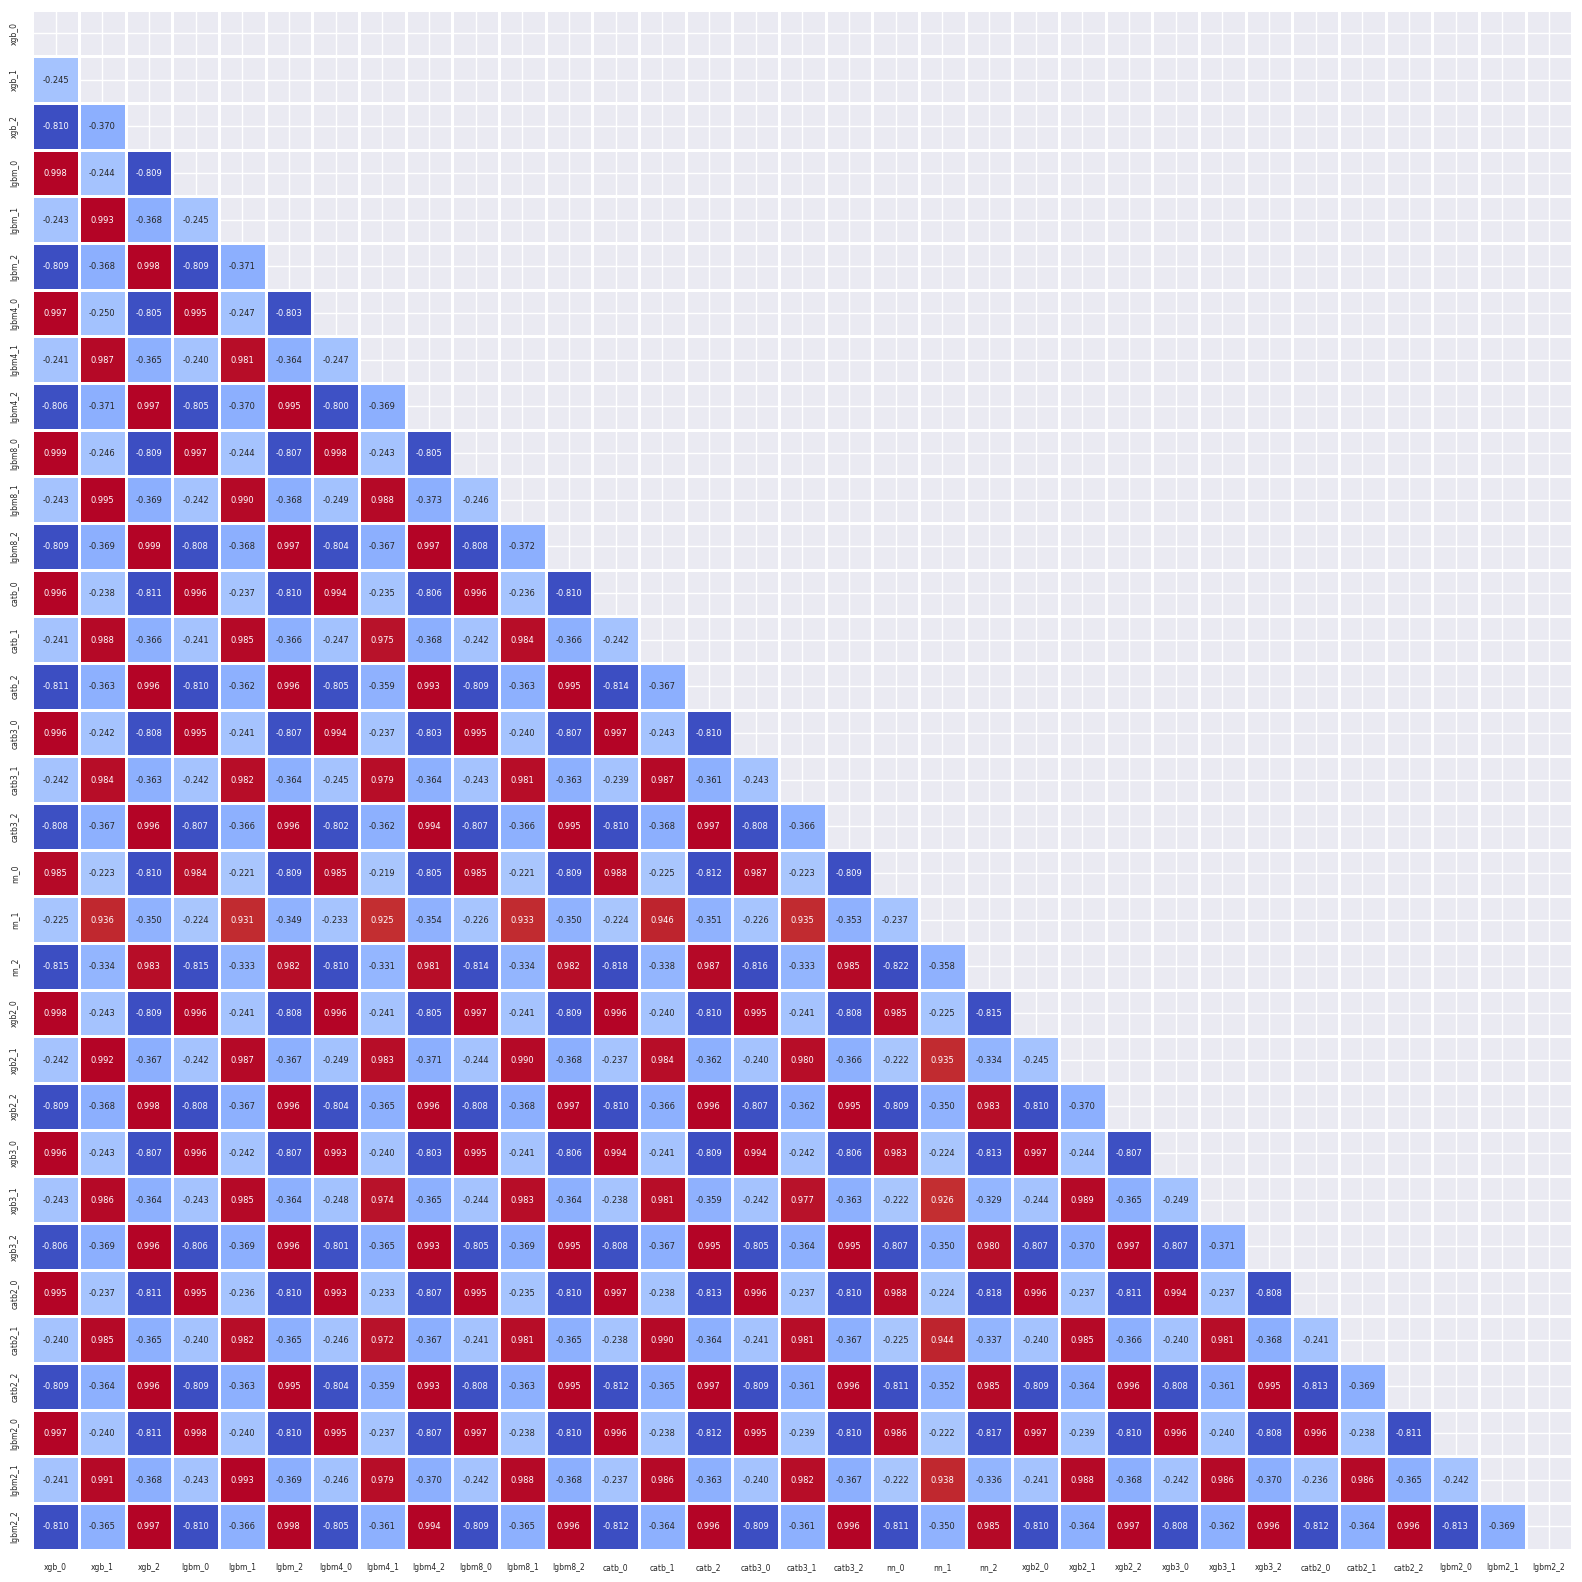

In [50]:
# Model diversity check

sns.set(font_scale=.5)
correlation_train = oof_predictions_df.corr()
mask = np.triu(correlation_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_train,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False);

### Voting vs Stacking and selection

#### Voting

In [51]:
cv_summary.columns

Index(['xgb', 'lgbm', 'lgbm4', 'lgbm8', 'catb', 'catb3', 'nn', 'xgb2', 'xgb3',
       'catb2', 'lgbm2'],
      dtype='object')

In [52]:
def hard_voting_ensemble(oof_predictions_df, y_actual):
    # Sum the probabilities for each class across all models
    class_probabilities = np.zeros((len(oof_predictions_df), 3))
    
    for model in ['xgb', 'lgbm', 'lgbm4', 'catb', 'catb3', 'nn', 'xgb2', 'xgb3', 'catb2',
       'lgbm2']:  # Replace with actual model names
        class_probabilities += oof_predictions_df[[f'{model}_0', f'{model}_1', f'{model}_2']].values
    
    # Get the final class predictions based on the highest probability
    final_predictions = np.argmax(class_probabilities, axis=1)
    
    voting_accuracy = accuracy_score(final_predictions, y_actual)
    
    print(f'Ensemble Accuracy: {voting_accuracy:.5f}')
    
    return voting_accuracy

In [53]:
hard_voting_ensemble(oof_predictions_df, pipe_data.Target)

Ensemble Accuracy: 0.83409


0.834091324917013

#### Stacking

I tried logistic regression as meta classifier but it did not performed well. Then I change it to XGBoost. Following optuna code tunes XGBClassifier using oof_predictions_df and Target.

Some insights why logistic regression did not work:

* Logistic regression was originaly designed for binary classification problems. For multi-class it uses ‘ovr’, ‘multinomial’ strategies. But this strategies did not work well for this problem.

* For other possible reasons see discussion on this link: https://www.kaggle.com/competitions/playground-series-s4e6/discussion/509353#2853531

In [54]:
def objective(trial):

    # L1 regularization weight.
    n_estimators = trial.suggest_int("n_estimators", 1, 100)

    alpha1 = trial.suggest_float("alpha", 1e-8, 1.0, log=True)
    # sampling ratio for training data.
    subsample1 = trial.suggest_float("subsample", 0.2, 1.0)
    # sampling according to each tree.
    colsample_bytree1 = trial.suggest_float("colsample_bytree", 0.2, 1.0)
    # maximum depth of the tree, signifies complexity of the tree.
    max_depth1 = trial.suggest_int("max_depth", 3, 16)
    # minimum child weight, larger the term more conservative the tree.
    min_child_weight1 = trial.suggest_int("min_child_weight", 1, 8)
    # learning rate
    learning_rate1 =  trial.suggest_float("learning_rate", 1e-3, 0.5, log=True)
    # defines how selective algorithm is.
    gamma1 = trial.suggest_float("gamma", 1e-8, 1.0, log=True)


    xgb_regressor = XGBClassifier(n_estimators = n_estimators, alpha=alpha1,subsample=subsample1,colsample_bytree=colsample_bytree1,
                                  max_depth=max_depth1,min_child_weight =min_child_weight1,learning_rate=learning_rate1,gamma=gamma1,
                                  random_state =random_state)
    

    
    ss = cv
    score = cross_val_score(xgb_regressor, oof_predictions_df, pipe_data.Target, scoring= 'accuracy',  cv=ss)
    score = score.mean()
    return score


sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

[I 2024-10-08 00:28:59,302] A new study created in memory with name: no-name-8685858e-b40c-4dbf-8f2e-7a0ab2fb9769
[I 2024-10-08 00:29:17,978] Trial 0 finished with value: 0.8343788253033624 and parameters: {'n_estimators': 38, 'alpha': 0.40338008326003827, 'subsample': 0.7855951534491241, 'colsample_bytree': 0.6789267873576292, 'max_depth': 5, 'min_child_weight': 2, 'learning_rate': 0.001434715951720141, 'gamma': 0.08499808989182997}. Best is trial 0 with value: 0.8343788253033624.
[I 2024-10-08 00:30:37,097] Trial 1 finished with value: 0.8332941236269387 and parameters: {'n_estimators': 61, 'alpha': 0.004619347374377372, 'subsample': 0.21646759543664196, 'colsample_bytree': 0.9759278817295955, 'max_depth': 14, 'min_child_weight': 2, 'learning_rate': 0.003095566460242371, 'gamma': 2.9324868872723725e-07}. Best is trial 0 with value: 0.8343788253033624.
[I 2024-10-08 00:31:09,578] Trial 2 finished with value: 0.8331242111986418 and parameters: {'n_estimators': 31, 'alpha': 0.0001577798

def objective(trial):

In [56]:
def objective(trial):

    # Suggest hyperparameters
    C = trial.suggest_float("C", 1e-4, 10, log=True)
    max_iter = trial.suggest_int("max_iter", 100, 4000)
    tol = trial.suggest_float("tol", 1e-6, 1e-3, log=True)
    solver = trial.suggest_categorical("solver", ["lbfgs",  "sag", "saga"])

    # Penalty is limited to 'l1' and 'elasticnet' when solver is 'liblinear'
    if solver == "liblinear":
        penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
    elif solver in ["lbfgs", "sag"]:
        penalty = "l2"
    elif solver == "saga":
        penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    else:
        penalty = "l2"

    if penalty == "elasticnet":
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    else:
        l1_ratio = None
    
    # Load dataset


    # Create a logistic regression model with suggested hyperparameters
    if l1_ratio is not None:
        model = LogisticRegression(C=C, max_iter=max_iter, tol=tol, solver=solver, penalty=penalty, l1_ratio=l1_ratio, multi_class='multinomial', random_state=random_state)
    else:
        model = LogisticRegression(C=C, max_iter=max_iter, tol=tol, solver=solver, penalty=penalty, multi_class='multinomial', random_state=random_state)

    # Create a pipeline with scaling and logistic regression
    ensemble_pipeline = make_pipeline(StandardScaler(), model)

    ss = cv
    score = cross_val_score(ensemble_pipeline, oof_predictions_df, pipe_data.Target, scoring= 'accuracy',  cv=ss)
    score = score.mean()
    return score

sampler = TPESampler(seed=random_state) # create a seed for the sampler for reproducibility study = optuna.create_study(direction="maximize", sampler=sampler) study.optimize(objective, n_trials=100)

In [57]:
#parameters suggested for meta model                                                                                                 
meta_model_params = {
    'n_estimators': 42, 'alpha': 0.4305218889789215, 'subsample': 0.6145406936396373, 
    'colsample_bytree': 0.8393617666759562, 'max_depth': 3, 'min_child_weight': 1, 
    'learning_rate': 0.0010000054154687152, 'gamma': 8.918497273956174e-07
}

meta_model = XGBClassifier(**meta_model_params, random_state=random_state)

Catboost and Neural Network have poor performance. I want to check whether adding them to the ensemble or not. For this purpose, I applied feature selection to oof_df.

In [58]:
%%time

# Create a pipeline with preprocessor, RFECV, and LGBMClassifier
pipeline = Pipeline([
    ('rfecv', RFECV(estimator=meta_model,
                    step=1,
                    cv=cv,
                    scoring="accuracy",
                    min_features_to_select=min_features_to_select,
                    n_jobs=-1,))
])

# Fit the pipeline on the training data
pipeline.fit(oof_predictions_df, pipe_data.Target)

#CV score
print("Best CV score: ")
selected_features = np.array( oof_predictions_df.columns)[pipeline.named_steps['rfecv'].support_]
print( pipeline.named_steps['rfecv'].cv_results_["mean_test_score"][len(selected_features) - 1])

# Selected features after RFECV
print('Number of evaluated features:', len(oof_predictions_df.columns))
print('Number of selected features:', len(selected_features))
print("Selected Features:", selected_features)

Best CV score: 
0.8346402042737401
Number of evaluated features: 33
Number of selected features: 22
Selected Features: ['xgb_0' 'xgb_1' 'xgb_2' 'lgbm_0' 'lgbm_1' 'lgbm_2' 'lgbm8_0' 'lgbm8_1'
 'lgbm8_2' 'catb_0' 'catb_2' 'catb3_0' 'xgb2_0' 'xgb2_1' 'xgb2_2' 'xgb3_1'
 'xgb3_2' 'catb2_0' 'catb2_1' 'lgbm2_0' 'lgbm2_1' 'lgbm2_2']
CPU times: user 5min 53s, sys: 1.42 s, total: 5min 54s
Wall time: 5min 55s


### parameters suggested for meta model

In [59]:
meta_model_params = {'multi_class':'multinomial', 'C': 0.00876285849108136, 
                     'max_iter': 1514, 'tol': 2.9289499245474987e-06, 
                     'solver': 'lbfgs', 'penalty' : "l2", 'random_state': random_state
}

meta_model = LogisticRegression(**meta_model_params)

ensemble_pipeline = make_pipeline(StandardScaler(), meta_model)

### Create a pipeline with preprocessor, RFECV, and LGBMClassifier

In [60]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rfecv', RFECV(estimator=meta_model,
                    step=1,
                    cv=cv,
                    scoring="accuracy",
                    min_features_to_select=min_features_to_select,
                    n_jobs=-1,))
])

### Fit the pipeline on the training data

In [61]:
pipeline.fit(oof_predictions_df, pipe_data.Target)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rfecv',
                 RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                       estimator=LogisticRegression(C=0.00876285849108136,
                                                    max_iter=1514,
                                                    multi_class='multinomial',
                                                    random_state=42,
                                                    tol=2.9289499245474987e-06),
                       n_jobs=-1, scoring='accuracy'))])

### CV score

In [63]:
print("Best CV score: ") 

Best CV score: 


In [68]:
#selected_features = np.array(oof_predictions_df.columns)[pipeline.named_steps['rfecv']] 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [70]:
#print(pipeline.named_steps['rfecv'].cvresults["mean_test_score"][len(selected_features) - 1])

AttributeError: 'RFECV' object has no attribute 'cv_results'

### Selected features after RFECV

In [73]:
print('Number of evaluated features:', len(oof_predictions_df.columns)) 

print('Number of selected features:', len(selected_features)) 

print("Selected Features:", selected_features)

Number of evaluated features: 33
Number of selected features: 22
Selected Features: ['xgb_0' 'xgb_1' 'xgb_2' 'lgbm_0' 'lgbm_1' 'lgbm_2' 'lgbm8_0' 'lgbm8_1'
 'lgbm8_2' 'catb_0' 'catb_2' 'catb3_0' 'xgb2_0' 'xgb2_1' 'xgb2_2' 'xgb3_1'
 'xgb3_2' 'catb2_0' 'catb2_1' 'lgbm2_0' 'lgbm2_1' 'lgbm2_2']


#### Stacking seems better.

In [74]:
selected_features

array(['xgb_0', 'xgb_1', 'xgb_2', 'lgbm_0', 'lgbm_1', 'lgbm_2', 'lgbm8_0',
       'lgbm8_1', 'lgbm8_2', 'catb_0', 'catb_2', 'catb3_0', 'xgb2_0',
       'xgb2_1', 'xgb2_2', 'xgb3_1', 'xgb3_2', 'catb2_0', 'catb2_1',
       'lgbm2_0', 'lgbm2_1', 'lgbm2_2'], dtype=object)

In [75]:
# fit only ['xgb' 'lgbm' 'catb']
meta_model = meta_model.fit(oof_predictions_df[selected_features], pipe_data.Target)

In [77]:
preds_test =  meta_model.predict(submission_predictions_df[selected_features])

### Submission

In [78]:
output = pd.DataFrame({'id': pipe_test.index,
                       'Target': preds_test})
output["Target"] = label_encoder.inverse_transform(output["Target"])

In [79]:
output.to_csv('submission.csv', index=False)

In [80]:
output.head()

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
